## Assignment 3: Recurrent Neural Networks for Stock Price Prediction


This assignment is to implement, describe, and test Recurrent Neural Networks (RNNs) to predict stock prices in the future.

In [1]:
# Importing libraries. 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR


# Avoid non-essential warnings 
# import warnings
# warnings.filterwarnings('ignore')


### 1 Data Exploration and Analysis

In [2]:
data = pd.read_csv("AAPL.csv")

In [3]:
data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10590 non-null  object 
 1   Low             10590 non-null  float64
 2   Open            10590 non-null  float64
 3   Volume          10590 non-null  int64  
 4   High            10590 non-null  float64
 5   Close           10590 non-null  float64
 6   Adjusted Close  10590 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 579.3+ KB


There is no Nan value of the dataset and all features are numerical except 'Date'.

In [5]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

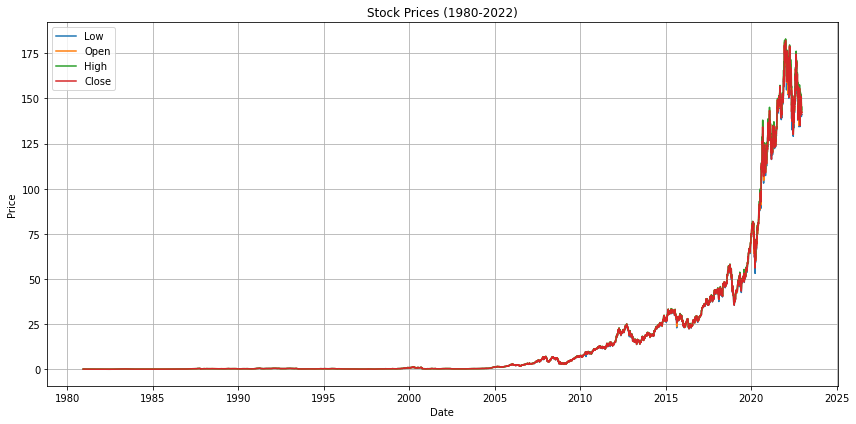

In [6]:
plt.figure(figsize=(12, 6))

plt.plot(data['Date'],data['Low'], label='Low')
plt.plot(data['Date'], data['Open'], label='Open')
plt.plot(data['Date'], data['High'], label='High')
plt.plot(data['Date'], data['Close'], label='Close')

plt.legend()
plt.title('Stock Prices (1980-2022)')
plt.xlabel('Date')
plt.ylabel('Price')

plt.grid(True)
plt.tight_layout()
plt.show()

Back to 1980, stock price of Apple is rather low than that in 2010s, the enconomy of the world has changed. With the influence of development of artifical intellegence and covid-19 in recently years, it is better to filter data in 5-10 years to catch the features of most relevant years. We use data from 2017, when Apple has become the no.1 mobile phone brand.

In [7]:
df = data[(data['Date'] >= '2017-01-01')]

In [8]:
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
9093,2017-01-03,28.690001,28.950001,115127600,29.082500,29.037500,27.174759
9094,2017-01-04,28.937500,28.962500,84472400,29.127501,29.004999,27.144337
9095,2017-01-05,28.952499,28.980000,88774400,29.215000,29.152500,27.282375
9096,2017-01-06,29.117500,29.195000,127007600,29.540001,29.477501,27.586531
9097,2017-01-09,29.485001,29.487499,134247600,29.857500,29.747499,27.839211


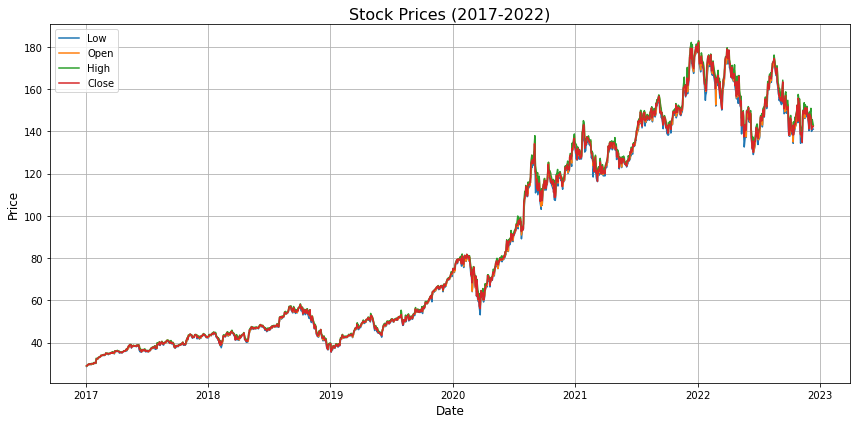

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'], df['Low'], label='Low')
plt.plot(df['Date'], df['Open'], label='Open')
plt.plot(df['Date'], df['High'], label='High')
plt.plot(df['Date'], df['Close'], label='Close')

plt.legend()
plt.title('Stock Prices (2017-2022)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)


plt.grid(True)
plt.tight_layout()
plt.show()

We can see that from 2017 the stock price of Apple is increasing until 2020 it dropped in a big scale. 

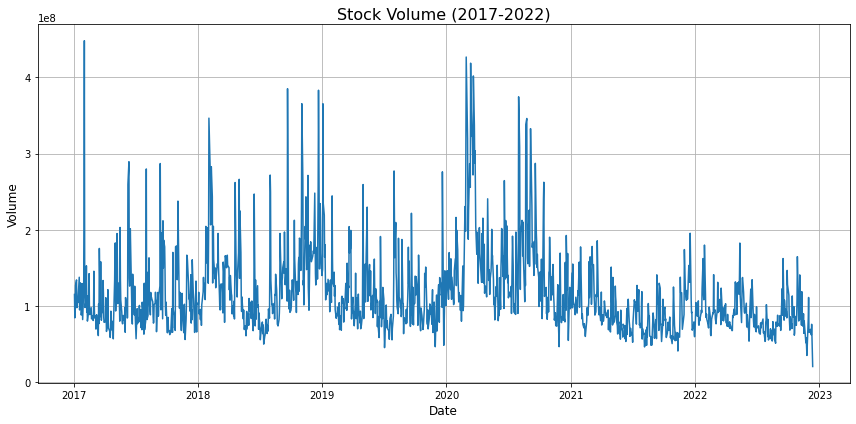

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(df['Date'], df['Volume'])

plt.title('Stock Volume (2017-2022)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)


plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Dataset Splitting and Pre-processing

In [11]:
print("The size of data from 2017 to 2022 is: ",len(df))

The size of data from 2017 to 2022 is:  1497


Considering stock price prediction is usually in 30 days or few days in the future. We have test size of 30 that can be used for test the result in 3 days or 30 days.

In [12]:
test_size = int(0.15*len(df))
train_val_size = len(df) - test_size

full_train_data = df[:train_val_size]  
test_data = df[train_val_size:]      

train_size = int(len(full_train_data) * 0.8235) # Train data is 70% of the whole dataset

train_data = full_train_data[:train_size] 
val_data = full_train_data[train_size:]  

print(f"Size of train data: {len(train_data)}")
print(f"Size of validation data: {len(val_data)}")
print(f"Size of test data: {len(test_data)}")

Size of train data: 1048
Size of validation data: 225
Size of test data: 224


In [13]:
train_data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
9093,2017-01-03,28.690001,28.950001,115127600,29.082500,29.037500,27.174759
9094,2017-01-04,28.937500,28.962500,84472400,29.127501,29.004999,27.144337
9095,2017-01-05,28.952499,28.980000,88774400,29.215000,29.152500,27.282375
9096,2017-01-06,29.117500,29.195000,127007600,29.540001,29.477501,27.586531
9097,2017-01-09,29.485001,29.487499,134247600,29.857500,29.747499,27.839211


In [14]:
features = ['Open', 'High', 'Low', 'Close','Volume']
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[features])
scaled_valid = scaler.transform(val_data[features])

In [15]:
train_data[features].describe()

,Open,High,Low,Close,Volume
count,1048.000000,1048.000000,1048.000000,1048.000000,1.048000e+03
mean,60.992321,61.676904,60.313039,61.025656,1.277898e+08
std,28.676950,29.107745,28.127150,28.625848,5.791802e+07
min,28.950001,29.082500,28.690001,29.004999,4.544800e+07
25%,41.734376,42.265000,41.312501,41.817499,8.821798e+07
50%,49.233749,49.844999,48.656250,49.272499,1.118064e+08
75%,70.743124,71.815628,70.108749,71.419374,1.490569e+08
max,143.600006,145.089996,141.369995,143.160004,4.479400e+08


In [16]:
# Setting seed so that value won't change everytime. 
torch.manual_seed(10)

In [17]:
# Define time series data
def create_dataset(data, time_steps=10, future_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - future_steps + 1):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps:i + time_steps + future_steps])  
    return np.array(X), np.array(y)

In [18]:
X_train, y_train = create_dataset(scaled_train)
X_valid, y_valid = create_dataset(scaled_valid)

In [19]:
y_train_open = y_train[:, :, 0]
y_valid_open = y_valid[:, :, 0]

y_train_high = y_train[:, :, 1]
y_valid_high = y_valid[:, :, 1]

y_train_low = y_train[:, :, 2]
y_valid_low = y_valid[:, :, 2]

y_train_close = y_train[:, :, 3]
y_valid_close = y_valid[:, :, 3]

In [20]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# y_valid = torch.tensor(y_valid, dtype=torch.float32)

y_train_open = torch.tensor(y_train_open, dtype=torch.float32)
y_valid_open = torch.tensor(y_valid_open, dtype=torch.float32)

y_train_high = torch.tensor(y_train_high, dtype=torch.float32)
y_valid_high = torch.tensor(y_valid_high, dtype=torch.float32)

y_train_low = torch.tensor(y_train_low, dtype=torch.float32)
y_valid_low = torch.tensor(y_valid_low, dtype=torch.float32)

y_train_close = torch.tensor(y_train_close, dtype=torch.float32)
y_valid_close = torch.tensor(y_valid_close, dtype=torch.float32)

In [21]:
print("X_train shape:", X_train.shape) 
print("y_train shape:", y_valid_close.shape)

X_train shape: torch.Size([1038, 10, 5])
y_train shape: torch.Size([215, 1])


### 3 Baseline -- Vanilla RNN

In [22]:
# RNN
class RNNBaseline(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNBaseline, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) 
        out = self.fc(out[:, -1, :])
        return out


In [23]:
def train_model(model, X_train, y_train, X_valid, y_valid, optimizer, num_epochs=30, print_epoch=False, 
                earlystop=5, batch_size=32, criterion = nn.L1Loss()):

    train_losses = []
    valid_losses = []

    # get batches
    def get_batches(X, y, batch_size):
        for i in range(0, len(X), batch_size):
            yield X[i:i + batch_size], y[i:i + batch_size]
    
    best_valid_loss = float('inf') 
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)  

        train_loss = epoch_loss / len(y_train)  
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0
        valid_outputs_all = []
        with torch.no_grad():
            for X_batch, y_batch in get_batches(X_valid, y_valid, batch_size):
                valid_outputs = model(X_batch)
                valid_outputs_all.append(valid_outputs)
                valid_loss += criterion(valid_outputs, y_batch).item() * X_batch.size(0)  

        valid_outputs_all = torch.cat(valid_outputs_all, dim=0) 
        valid_loss /= len(y_valid)  
        valid_losses.append(valid_loss)

        if print_epoch:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}")
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stop_counter = 0  
        else:
            early_stop_counter += 1

        if early_stop_counter >= earlystop:
            print(f"Early stopping triggered at epoch {epoch+1}. Best validation loss: {best_valid_loss:.6f}")
            break

    return train_losses, valid_losses, valid_outputs_all 


In [24]:
def plot_results(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def plot_close(y_test_original_close, predicted_test, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_original_close, label='Actual')
    plt.plot(predicted_test, label='Predicted')
    plt.title(f'Valid result - {title}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [26]:
input_size = X_train.shape[2]
hidden_size = 50
output_size = y_train_close.shape[1]

model_baseline = RNNBaseline(input_size, hidden_size, output_size)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=0.0001)
num_epochs = 20
batch_size = 32

In [27]:
train_loss_bl, valid_loss_bl, valid_outputs_bl= train_model(model=model_baseline, X_train=X_train, y_train=y_train_close, 
                                     X_valid=X_valid, y_valid=y_valid_close, optimizer=optimizer, print_epoch=True)

Epoch 1/30, Train Loss: 0.173066, Valid Loss: 0.756235
Epoch 2/30, Train Loss: 0.145181, Valid Loss: 0.672327
Epoch 3/30, Train Loss: 0.137449, Valid Loss: 0.613000
Epoch 4/30, Train Loss: 0.127850, Valid Loss: 0.560529
Epoch 5/30, Train Loss: 0.115189, Valid Loss: 0.501911
Epoch 6/30, Train Loss: 0.100629, Valid Loss: 0.432212
Epoch 7/30, Train Loss: 0.082663, Valid Loss: 0.343921
Epoch 8/30, Train Loss: 0.060496, Valid Loss: 0.231725
Epoch 9/30, Train Loss: 0.028298, Valid Loss: 0.091880
Epoch 10/30, Train Loss: 0.024300, Valid Loss: 0.092236
Epoch 11/30, Train Loss: 0.034190, Valid Loss: 0.119641
Epoch 12/30, Train Loss: 0.019941, Valid Loss: 0.096743
Epoch 13/30, Train Loss: 0.021812, Valid Loss: 0.093182
Epoch 14/30, Train Loss: 0.024194, Valid Loss: 0.093824
Early stopping triggered at epoch 14. Best validation loss: 0.091880


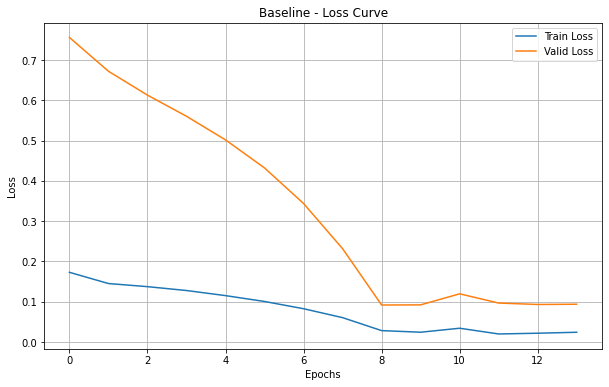

In [28]:
plot_results(train_loss_bl, valid_loss_bl, 'Baseline')

In [29]:
close_max = train_data['Close'].max()
close_min = train_data['Close'].min()

In [30]:
y_valid_original = (y_valid_close.numpy())*(close_max -close_min )+close_min

In [31]:
outputs_bl = (valid_outputs_bl.numpy())*(close_max -close_min )+close_min

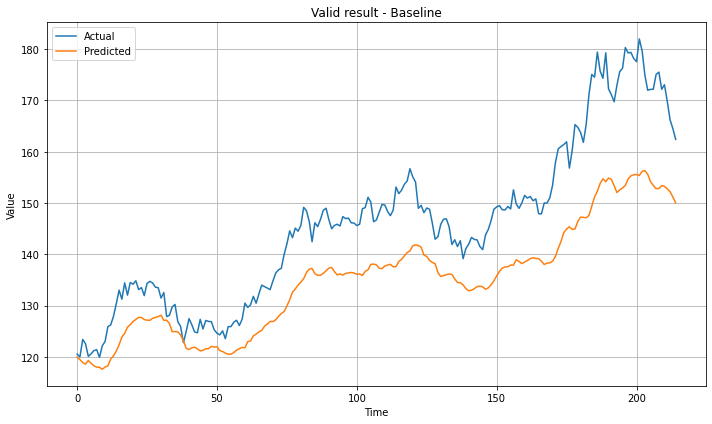

In [32]:
plot_close(y_valid_original, outputs_bl, 'Baseline')

In [33]:
mse_bl = mean_squared_error(y_valid_original, outputs_bl)
mae_bl = mean_absolute_error(y_valid_original, outputs_bl)

In [34]:
losses = dict()
losses['Baseline']= {'MAE': mae_bl, 'RMSE': np.sqrt(mse_bl)}

We can see that the model converges at last with no oscallation. Then we can use learning rate 0.0001 as a start during the optimization.

In [35]:
from torchsummary import summary

In [36]:
print(model_baseline)

RNNBaseline(
  (rnn): RNN(5, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [37]:
print(f'MAE: {mae_bl:.4f}, RMSE: {np.sqrt(mse_bl):.4f}')


MAE: 10.7105, RMSE: 12.2158


### 4 Optimizition

### 4.1 Set models

In [38]:

class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, use_dropout=False, dropout_rate=0.3):
        super(RNN_Model, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 and use_dropout else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.use_dropout:
            out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


In [39]:

class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, use_dropout=False, dropout_rate=0.3):
        super(GRU_Model, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 and use_dropout else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out, _ = self.gru(x)
        if self.use_dropout:
            out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


In [40]:

class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, use_dropout=False, dropout_rate=0.3):
        super(LSTM_Model, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 and use_dropout else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.use_dropout = use_dropout
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out, _ = self.lstm(x)
        if self.use_dropout:
            out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


### 4.2 Hyperparameters

In [41]:
rnn_param_grid = {
    'hidden_size': [20, 50],
    'num_layers': [2, 3],
    'use_dropout': [True],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [1e-4, 5e-5]
}


gru_param_grid = {
    'hidden_size': [300, 500],
    'num_layers': [3, 5],
    'use_dropout': [True],
    'dropout_rate': [0.2, 0.4],
    'learning_rate': [1e-5, 5e-6]
}


lstm_param_grid = {
    'hidden_size': [50, 100],
    'num_layers': [2, 3],
    'use_dropout': [True],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [1e-4, 5e-5]
}


In [42]:
def search_best_rnn(model_name, param_grid, X_train, y_train, X_valid, y_valid, 
                    num_epochs=30, batch_size=32, earlystop=5, print_epoch=False):
    
    best_model = None
    best_params = None
    best_result = None
    best_score = float('inf')
    best_train_losses = None  
    best_valid_losses = None 
    result = dict()
    params = dict()
    model_num = ''
    num = 1
    
    for hidden_size in param_grid['hidden_size']:
        for num_layers in param_grid['num_layers']:
            for use_dropout in param_grid['use_dropout']:
                for dropout_rate in param_grid['dropout_rate']:
                    for learning_rate in param_grid['learning_rate']:
                        
                        output_size = y_train.shape[1]
                        
                        model_num = f"{model_name}-{num}"

                        params = {'hidden_size': hidden_size,
                                    'num_layers': num_layers,
                                    'use_dropout': use_dropout,
                                    'dropout_rate': dropout_rate,
                                    'learning_rate': learning_rate
                                   }    
                        print(f"{model_num} - Params: {params}")
                        
                        if model_name == 'RNN':                           
                            model = RNN_Model(
                                input_size=X_train.shape[2],
                                hidden_size=hidden_size,
                                output_size=output_size,
                                num_layers=num_layers,
                                use_dropout=use_dropout,
                                dropout_rate=dropout_rate
                            )
                        elif model_name == 'GRU':
                            model = GRU_Model(
                                input_size=X_train.shape[2],
                                hidden_size=hidden_size,
                                output_size=output_size,
                                num_layers=num_layers,
                                use_dropout=use_dropout,
                                dropout_rate=dropout_rate
                            )                            
                        elif model_name == 'LSTM':
                            model = LSTM_Model(
                                input_size=X_train.shape[2],
                                hidden_size=hidden_size,
                                output_size=output_size,
                                num_layers=num_layers,
                                use_dropout=use_dropout,
                                dropout_rate=dropout_rate
                            )                                  
                        else:
                            print("Invalid model name.")
                            continue
                            
                        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                        
                        train_losses, valid_losses, valid_output = train_model(
                            model=model,
                            X_train=X_train,
                            y_train=y_train,
                            X_valid=X_valid,
                            y_valid=y_valid,
                            optimizer=optimizer,
                            num_epochs=num_epochs,
                            batch_size=batch_size,
                            earlystop=earlystop,
                        )
                        
                        final_valid_loss = valid_losses[-1]

                        if final_valid_loss < best_score:
                            best_score = final_valid_loss
                            best_model = model
                            best_result = valid_output
                            best_params = {
                                'hidden_size': hidden_size,
                                'num_layers': num_layers,
                                'use_dropout': use_dropout,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate
                            }
                            best_train_losses = train_losses
                            best_valid_losses = valid_losses
                            
                        print(f"Train Loss: {train_losses[-1]:.6f}, Valid Loss: {valid_losses[-1]:.6f}\n")
                        result[model_num]={'Params': params, 'Train Losses':train_losses, 'Valid Losses':valid_losses, 'Valid Outputs': valid_output}
                        num += 1
    return best_model, best_params, best_score, best_train_losses, best_valid_losses, best_result, result


In [43]:

def plot_all_results(result, rows=8, cols=4, figsize=(20, 20)):

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() 

    for i, (model_num, results) in enumerate(result.items()):
        if i >= rows * cols:  
            break
        
        trainloss= results['Train Losses']
        validloss= results['Valid Losses']
        params = results['Params']
        
        ax = axes[i]
        
        ax.plot(trainloss, label='Train Loss')
        ax.plot(validloss, label='Valid Loss')
        
        ax.set_title(f"{model_num}\nHidden: {params['hidden_size']}, Layers: {params['num_layers']}, Learning rate: {params['learning_rate']}")
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


### RNN

In [44]:
 best_model_rnn, best_params_rnn, best_score_rnn, best_train_losses_rnn, best_valid_losses_rnn, best_result_rnn, result_rnn = search_best_rnn(
    model_name='RNN',
    param_grid=rnn_param_grid,
    X_train=X_train,
    y_train=y_train_close,
    X_valid=X_valid,
    y_valid=y_valid_close,
)


RNN-1 - Params: {'hidden_size': 20, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
Train Loss: 0.083018, Valid Loss: 0.211292

RNN-2 - Params: {'hidden_size': 20, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 5e-05}
Train Loss: 0.071934, Valid Loss: 0.154116

RNN-3 - Params: {'hidden_size': 20, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.3, 'learning_rate': 0.0001}
Early stopping triggered at epoch 22. Best validation loss: 0.156500
Train Loss: 0.070875, Valid Loss: 0.159538

RNN-4 - Params: {'hidden_size': 20, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.3, 'learning_rate': 5e-05}
Train Loss: 0.079069, Valid Loss: 0.234541

RNN-5 - Params: {'hidden_size': 20, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
Train Loss: 0.069847, Valid Loss: 0.209258

RNN-6 - Params: {'hidden_size': 20, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 5

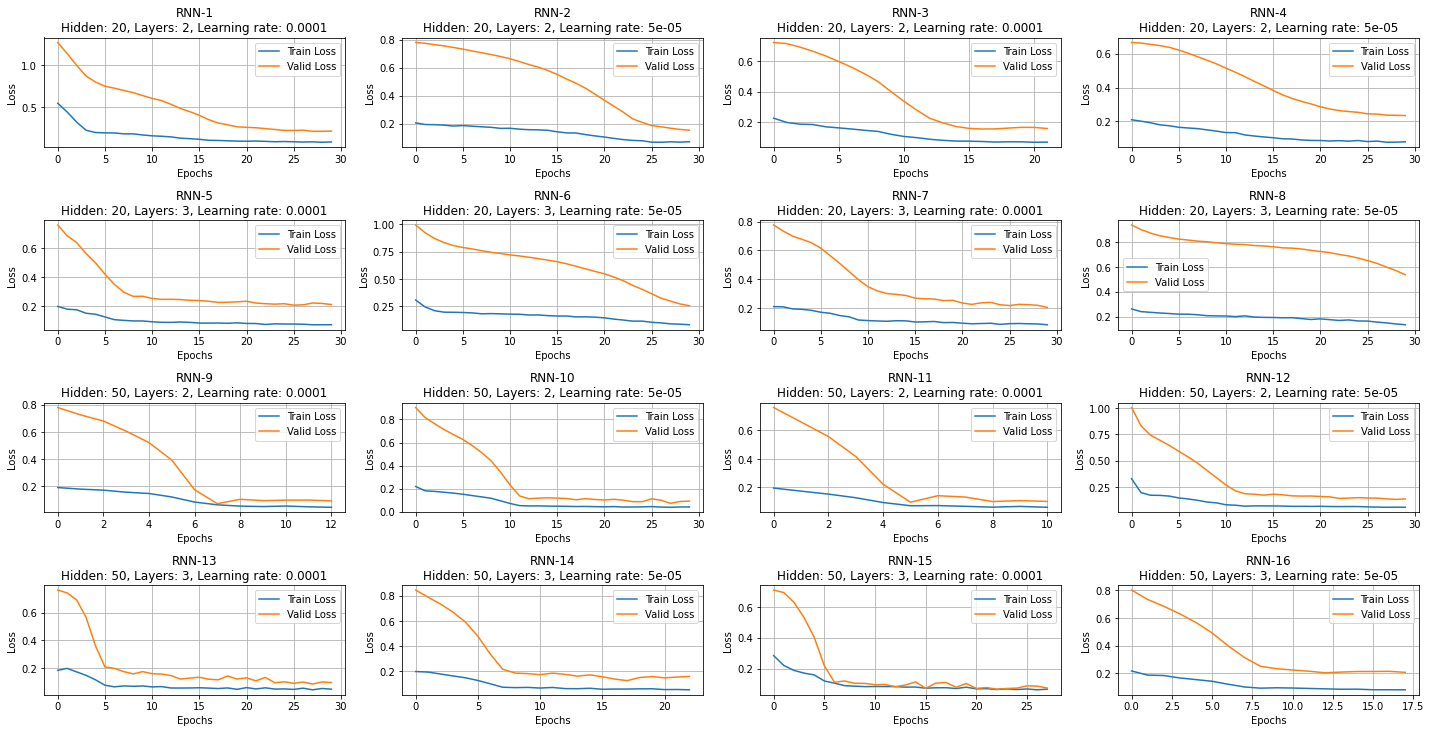

In [45]:
plot_all_results(result_rnn)

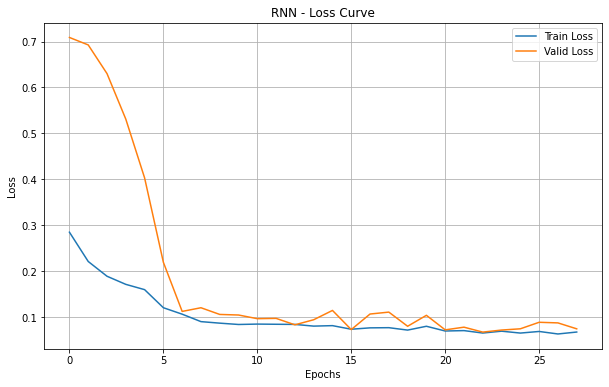

In [46]:
plot_results(best_train_losses_rnn, best_valid_losses_rnn, 'RNN')

In [47]:
best_params_rnn

{'hidden_size': 50,
 'num_layers': 3,
 'use_dropout': True,
 'dropout_rate': 0.3,
 'learning_rate': 0.0001}

In [48]:
print(f"Best Parameters: {best_params_rnn}")
print(f"Best Validation Loss: {best_score_rnn:.6f}")

Best Parameters: {'hidden_size': 50, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.3, 'learning_rate': 0.0001}
Best Validation Loss: 0.074235


In [49]:
valid_outputs_rnn = (best_result_rnn.numpy())*(close_max -close_min )+close_min

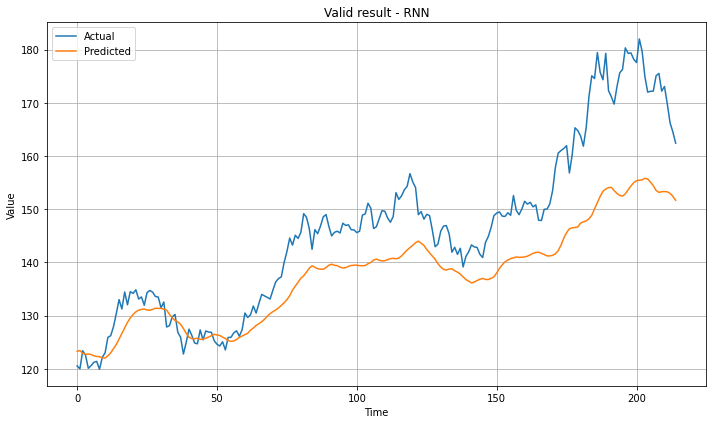

In [50]:
plot_close(y_valid_original, valid_outputs_rnn, 'RNN')

In [51]:
mse_rnn = mean_squared_error(y_valid_original, valid_outputs_rnn)
mae_rnn = mean_absolute_error(y_valid_original, valid_outputs_rnn)
losses['RNN']= {'MAE': mae_rnn, 'RMSE': np.sqrt(mse_rnn)}

In [52]:
print(best_model_rnn)

RNN_Model(
  (rnn): RNN(5, 50, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [53]:
print(f'MAE: {mae_rnn:.4f}, RMSE: {np.sqrt(mse_rnn):.4f}')

MAE: 8.4743, RMSE: 10.8446


### GRU

In [54]:
 best_model_gru, best_params_gru, best_score_gru, best_train_losses_gru, best_valid_losses_gru, best_result_gru, result_gru = search_best_rnn(
    model_name='GRU',
    param_grid=gru_param_grid,
    X_train=X_train,
    y_train=y_train_close,
    X_valid=X_valid,
    y_valid=y_valid_close,
    num_epochs=20,
    batch_size=32
)



GRU-1 - Params: {'hidden_size': 300, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 1e-05}
Train Loss: 0.024104, Valid Loss: 0.028588

GRU-2 - Params: {'hidden_size': 300, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 5e-06}
Train Loss: 0.085834, Valid Loss: 0.357570

GRU-3 - Params: {'hidden_size': 300, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.4, 'learning_rate': 1e-05}
Train Loss: 0.032798, Valid Loss: 0.028261

GRU-4 - Params: {'hidden_size': 300, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.4, 'learning_rate': 5e-06}
Train Loss: 0.099884, Valid Loss: 0.422272

GRU-5 - Params: {'hidden_size': 300, 'num_layers': 5, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 1e-05}
Train Loss: 0.028668, Valid Loss: 0.033747

GRU-6 - Params: {'hidden_size': 300, 'num_layers': 5, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 5e-06}
Train Loss: 0.106617, Valid Loss: 0.431328

GRU-7 - Params: 

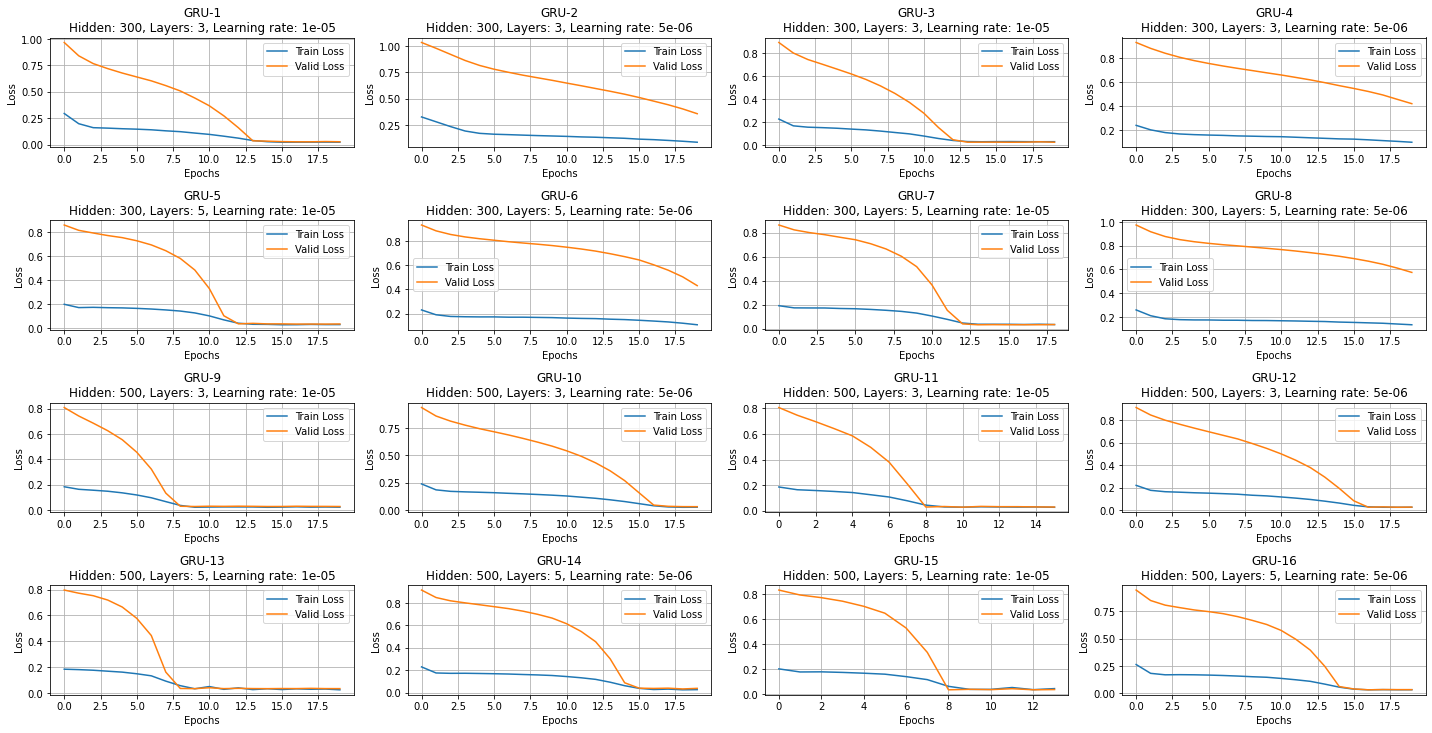

In [55]:
plot_all_results(result_gru)

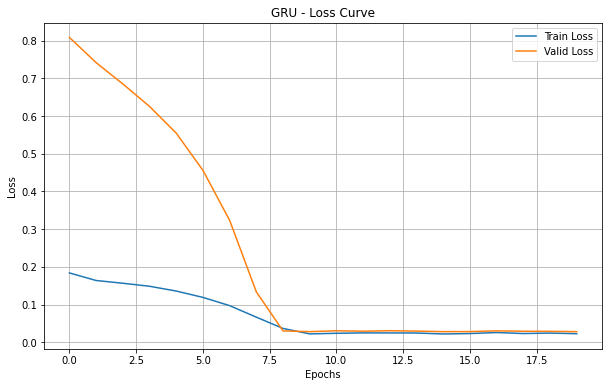

In [56]:
plot_results(best_train_losses_gru, best_valid_losses_gru, 'GRU')

In [57]:
best_params_gru

{'hidden_size': 500,
 'num_layers': 3,
 'use_dropout': True,
 'dropout_rate': 0.2,
 'learning_rate': 1e-05}

In [58]:
print(f"Best Parameters: {best_params_gru}")
print(f"Best Validation Loss: {best_score_gru:.6f}")

Best Parameters: {'hidden_size': 500, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 1e-05}
Best Validation Loss: 0.027996


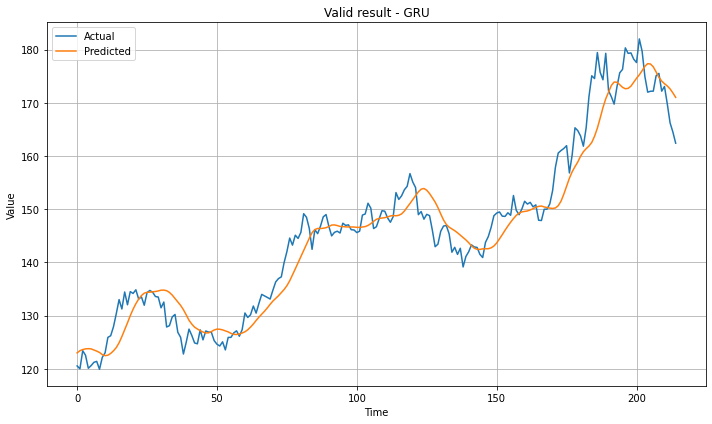

In [59]:
valid_outputs_gru = (best_result_gru.numpy())*(close_max -close_min )+close_min
plot_close(y_valid_original, valid_outputs_gru, 'GRU')

In [60]:
mse_gru = mean_squared_error(y_valid_original, valid_outputs_gru)
mae_gru = mean_absolute_error(y_valid_original, valid_outputs_gru)
losses['GRU']= {'MAE': mae_gru, 'RMSE': np.sqrt(mse_gru)}

In [61]:
print(best_model_gru)

GRU_Model(
  (gru): GRU(5, 500, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [62]:
print(f'MAE: {mae_gru:.4f}, RMSE: {np.sqrt(mse_gru):.4f}')

MAE: 3.1959, RMSE: 4.1318


### LSTM

In [63]:
 best_model_lstm, best_params_lstm, best_score_lstm, best_train_losses_lstm, best_valid_losses_lstm, best_result_lstm, result_lstm = search_best_rnn(
    model_name='LSTM',
    param_grid=lstm_param_grid,
    X_train=X_train,
    y_train=y_train_close,
    X_valid=X_valid,
    y_valid=y_valid_close,
    num_epochs=20,
    batch_size=32
)

LSTM-1 - Params: {'hidden_size': 50, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
Early stopping triggered at epoch 15. Best validation loss: 0.029886
Train Loss: 0.034029, Valid Loss: 0.043641

LSTM-2 - Params: {'hidden_size': 50, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 5e-05}
Train Loss: 0.053626, Valid Loss: 0.030477

LSTM-3 - Params: {'hidden_size': 50, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.3, 'learning_rate': 0.0001}
Early stopping triggered at epoch 16. Best validation loss: 0.037844
Train Loss: 0.038343, Valid Loss: 0.073254

LSTM-4 - Params: {'hidden_size': 50, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.3, 'learning_rate': 5e-05}
Train Loss: 0.088181, Valid Loss: 0.206671

LSTM-5 - Params: {'hidden_size': 50, 'num_layers': 3, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.0001}
Early stopping triggered at epoch 16. Best validation loss: 0.040155
Train Loss: 0.

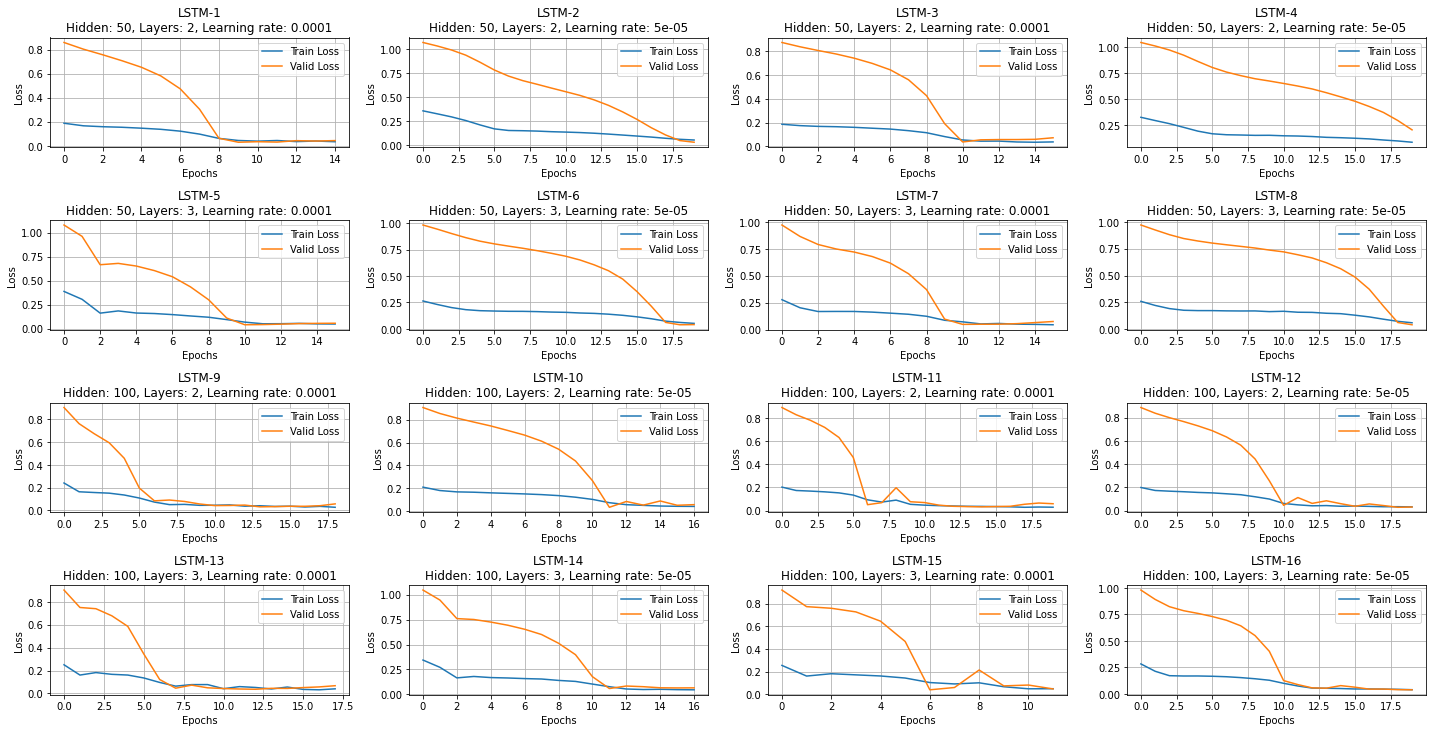

In [64]:
plot_all_results(result_lstm)

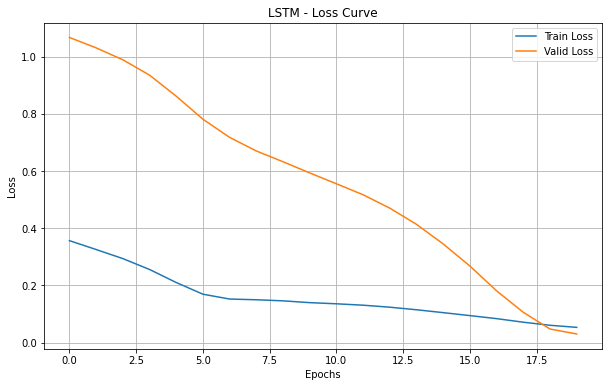

In [65]:
plot_results(best_train_losses_lstm, best_valid_losses_lstm, 'LSTM')

In [66]:
best_params_lstm

{'hidden_size': 50,
 'num_layers': 2,
 'use_dropout': True,
 'dropout_rate': 0.2,
 'learning_rate': 5e-05}

In [67]:
print(f"Best Parameters: {best_params_lstm}")
print(f"Best Validation Loss: {best_score_lstm:.6f}")

Best Parameters: {'hidden_size': 50, 'num_layers': 2, 'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 5e-05}
Best Validation Loss: 0.030477


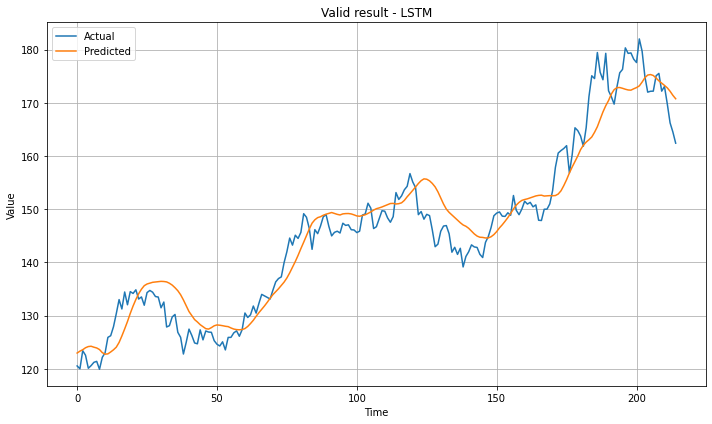

In [68]:
valid_outputs_lstm = (best_result_lstm.numpy())*(close_max -close_min )+close_min
plot_close(y_valid_original, valid_outputs_lstm, 'LSTM')

In [69]:
mse_lstm = mean_squared_error(y_valid_original, valid_outputs_lstm)
mae_lstm = mean_absolute_error(y_valid_original, valid_outputs_lstm)
losses['LSTM']= {'MAE': mae_lstm, 'RMSE': np.sqrt(mse_lstm)}

In [70]:
print(best_model_lstm)

LSTM_Model(
  (lstm): LSTM(5, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [71]:
print(f'MAE: {mae_lstm:.4f}, RMSE: {np.sqrt(mse_lstm):.4f}')

MAE: 3.4791, RMSE: 4.3579


### 4.3 Comparison

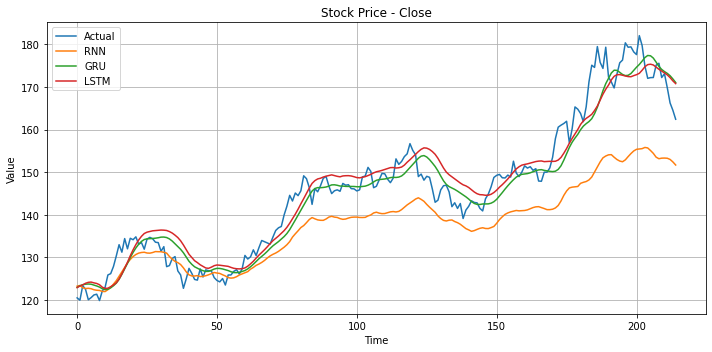

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(y_valid_original, label='Actual')
plt.plot(valid_outputs_rnn, label='RNN')
plt.plot(valid_outputs_gru, label='GRU')
plt.plot(valid_outputs_lstm, label='LSTM')
plt.title(f'Stock Price - Close')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

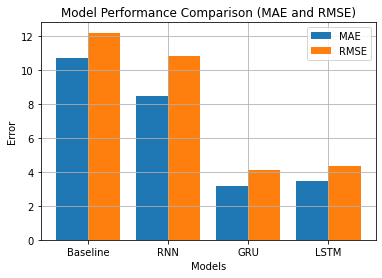

In [73]:
models = list(losses.keys())
mae_values = [losses[model]['MAE'] for model in losses]
rmse_values = [losses[model]['RMSE'] for model in losses]

x = range(len(models))
plt.bar(x, mae_values, width=0.4, label='MAE', align='center')
plt.bar([i + 0.4 for i in x], rmse_values, width=0.4, label='RMSE', align='center')

plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Model Performance Comparison (MAE and RMSE)')
plt.xticks([i + 0.2 for i in x], models)  
plt.legend()
plt.grid(True)
plt.show()

## 5 Best Model

In [74]:
scaler_full = MinMaxScaler()
scaled_full_train = scaler_full.fit_transform(full_train_data[features])
scaled_test = scaler_full.transform(test_data[features])

In [75]:
X_trainfull, y_trainfull = create_dataset(scaled_full_train)
X_test, y_test = create_dataset(scaled_test)

In [76]:
X_trainfull = torch.tensor(X_trainfull, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
# y_trainfull = torch.tensor(y_trainfull, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

In [77]:
y_trainfull_open = y_trainfull[:, :, 0]
y_test_open = y_test [:, :, 0]

y_trainfull_high = y_trainfull[:, :, 1]
y_test_high = y_test[:, :, 1]

y_trainfull_low = y_trainfull[:, :, 2]
y_test_low = y_test[:, :, 2]

y_trainfull_close = y_trainfull[:, :, 3]
y_test_close = y_test[:, :, 3]

In [78]:
y_trainfull_open= torch.tensor(y_trainfull_open, dtype=torch.float32)
y_test_open = torch.tensor(y_test_open, dtype=torch.float32)
y_trainfull_close = torch.tensor(y_trainfull_close, dtype=torch.float32)
y_test_close = torch.tensor(y_test_close, dtype=torch.float32)

In [79]:
best_params_gru

{'hidden_size': 500,
 'num_layers': 3,
 'use_dropout': True,
 'dropout_rate': 0.2,
 'learning_rate': 1e-05}

In [80]:
model_gru = GRU_Model(input_size=X_trainfull.shape[2],
                      hidden_size=best_params_gru['hidden_size'], 
                      output_size=y_trainfull.shape[1],
                      num_layers=3,
                      use_dropout=best_params_gru['use_dropout'], 
                      dropout_rate=1e-5 ) 

In [81]:
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr= best_params_gru['learning_rate'])

In [82]:
print(model_gru)

GRU_Model(
  (gru): GRU(5, 500, num_layers=3, batch_first=True, dropout=1e-05)
  (fc): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=1e-05, inplace=False)
)


In [83]:
train_loss_test, valid_loss_test, valid_outputs_test=train_model(model_gru, X_trainfull, y_trainfull_close, X_test, y_test_close, optimizer_gru, num_epochs=30, print_epoch=True)

Epoch 1/30, Train Loss: 0.203164, Valid Loss: 0.591868
Epoch 2/30, Train Loss: 0.206569, Valid Loss: 0.545297
Epoch 3/30, Train Loss: 0.190970, Valid Loss: 0.493794
Epoch 4/30, Train Loss: 0.170616, Valid Loss: 0.418805
Epoch 5/30, Train Loss: 0.142130, Valid Loss: 0.301600
Epoch 6/30, Train Loss: 0.097054, Valid Loss: 0.104021
Epoch 7/30, Train Loss: 0.042619, Valid Loss: 0.038477
Epoch 8/30, Train Loss: 0.015021, Valid Loss: 0.033915
Epoch 9/30, Train Loss: 0.019689, Valid Loss: 0.033661
Epoch 10/30, Train Loss: 0.019766, Valid Loss: 0.033632
Epoch 11/30, Train Loss: 0.020683, Valid Loss: 0.033628
Epoch 12/30, Train Loss: 0.019807, Valid Loss: 0.033470
Epoch 13/30, Train Loss: 0.021002, Valid Loss: 0.033661
Epoch 14/30, Train Loss: 0.020024, Valid Loss: 0.033525
Epoch 15/30, Train Loss: 0.020850, Valid Loss: 0.033772
Epoch 16/30, Train Loss: 0.020404, Valid Loss: 0.033509
Epoch 17/30, Train Loss: 0.019320, Valid Loss: 0.033257
Epoch 18/30, Train Loss: 0.020211, Valid Loss: 0.033362
E

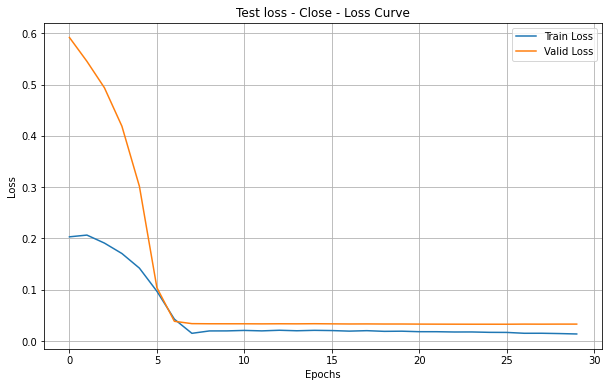

In [84]:
plot_results(train_loss_test, valid_loss_test, 'Test loss - Close')

In [85]:
close_maxfull = full_train_data['Close'].max()
close_minfull = full_train_data['Close'].min()

In [86]:
y_test_original_close = (y_test_close.numpy())*(close_maxfull -close_minfull )+close_minfull

In [87]:
predicted_test =(valid_outputs_test.numpy())*(close_maxfull -close_minfull )+close_minfull

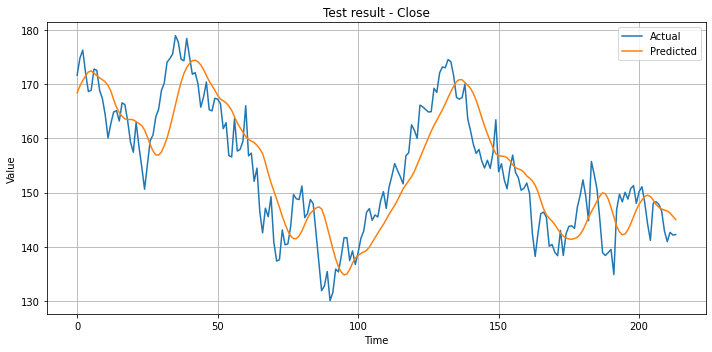

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_original_close, label='Actual')
plt.plot(predicted_test, label='Predicted')
plt.title('Test result - Close')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [89]:
mean_absolute_error(predicted_test,y_test_original_close)

5.048119

In [90]:
np.sqrt(mean_squared_error(predicted_test,y_test_original_close))

6.08228